<a href="https://colab.research.google.com/github/bikash-bhoi/EIP4/blob/master/Session6/Session_6_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [0]:
use_cuda = torch.cuda.is_available()

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
SEED=1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

torch.manual_seed(1)
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-13.0, 13.0), fill=(1,)),
                                       #transforms.RandomResizedCrop(size=28, scale=(0.75, 0.8)),
                                       transforms.
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


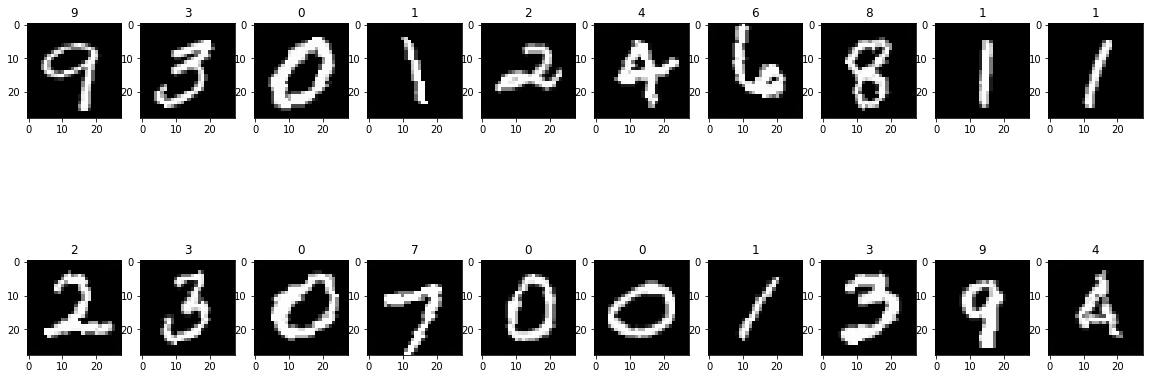

In [0]:
images, label = next(iter(train_loader))
fig = plt.figure(figsize=(20, 8))
for i in range(20):
  ax=fig.add_subplot(2, 10, i+1)
  img= np.squeeze(images[i].numpy())
  ax.imshow(img, cmap='gray')
  ax.set_title(str(label[i].item()))



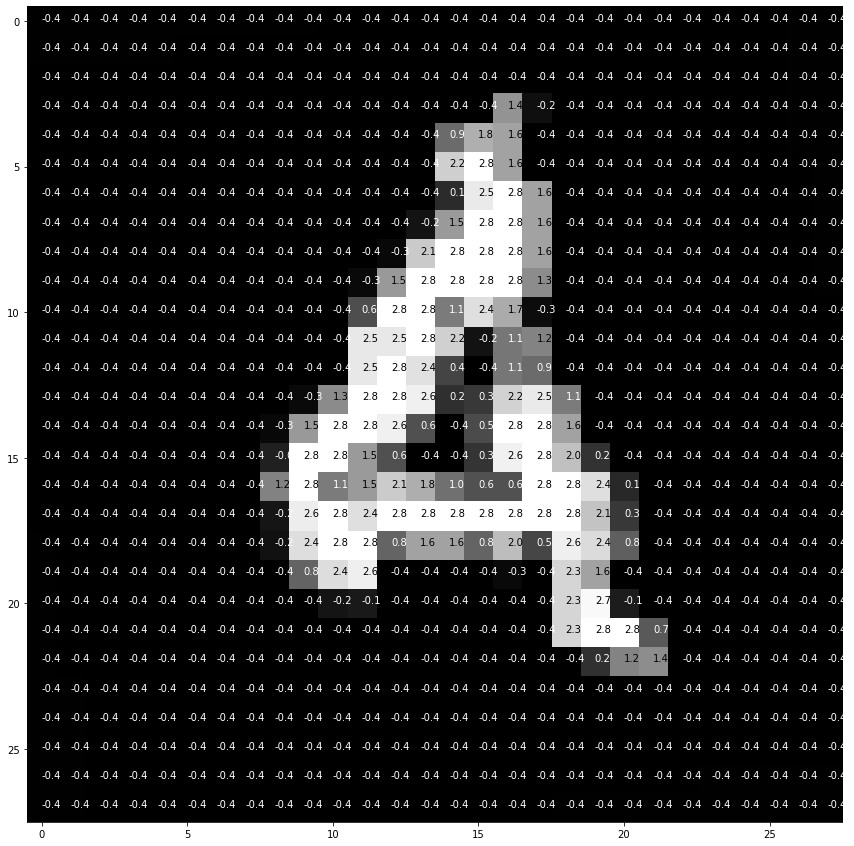

In [0]:
width, height = img.shape
fig= plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
ax.imshow(img, cmap='gray')
thresh =img.max()/2.5
for x in range(width):
  for y in range(height):
    val= round(img[x][y],1) if img[x][y] !=0 else 0
    ax.annotate(str(val), xy= (y,x),
                color='white' if val< thresh else 'black')

In [0]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

In [0]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv_block1= nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),#output size 26
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3),  bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(), #output size 24
    )
    self.trans_block1= nn.Sequential(
        nn.MaxPool2d(2,2),#output size 14
        
    )
    self.conv_block2= nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU(),  #output size 10

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(), #output size 8

       

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU() #output size 6
    )

    self.trans_block2= nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1))
    )

  def forward(self, x):
    x= self.conv_block1(x)
    x= self.trans_block1(x)
    x= self.conv_block2(x)
    x= self.trans_block2(x)
    x = x.view(-1, 10)
    return F.log_softmax(x)


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]             576
       BatchNorm2d-9            [-1, 8, 10, 10]              16
             ReLU-10            [-1, 8, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,152
      BatchNorm2d-12             [-1, 16, 8, 8]              32
             ReLU-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses_1 = []
train_acc = []
test_acc_1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_1.append(100. * correct / len(test_loader.dataset))

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.038953617215156555 Batch_id=937 Accuracy=90.66: 100%|██████████| 938/938 [00:17<00:00, 53.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9804/10000 (98.04%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.059532806277275085 Batch_id=937 Accuracy=97.37: 100%|██████████| 938/938 [00:17<00:00, 54.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9865/10000 (98.65%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.0475417822599411 Batch_id=937 Accuracy=97.58: 100%|██████████| 938/938 [00:16<00:00, 55.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9876/10000 (98.76%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.004969239234924316 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:17<00:00, 55.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9888/10000 (98.88%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.1808197945356369 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:16<00:00, 57.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0926, Accuracy: 9715/10000 (97.15%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.11662614345550537 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:16<00:00, 56.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9902/10000 (99.02%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.07645554840564728 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [00:16<00:00, 57.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9892/10000 (98.92%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.01368725299835205 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:16<00:00, 57.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9851/10000 (98.51%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.009203985333442688 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:17<00:00, 54.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9933/10000 (99.33%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.0015273094177246094 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:16<00:00, 67.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.037312284111976624 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:15<00:00, 69.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9891/10000 (98.91%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.03340354561805725 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:16<00:00, 58.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.023626863956451416 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:15<00:00, 59.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.1372353583574295 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:15<00:00, 59.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9912/10000 (99.12%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.0046906620264053345 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:15<00:00, 59.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.012551069259643555 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:16<00:00, 58.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.1380268633365631 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:16<00:00, 57.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.008658096194267273 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:16<00:00, 58.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9909/10000 (99.09%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.0004052072763442993 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:16<00:00, 58.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9911/10000 (99.11%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.012349620461463928 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:15<00:00, 59.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.002180814743041992 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:16<00:00, 58.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.0016289353370666504 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:16<00:00, 57.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.04905666410923004 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:15<00:00, 59.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.0220346599817276 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.0044727325439453125 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:15<00:00, 60.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.0004456937313079834 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:16<00:00, 56.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.0033495724201202393 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:15<00:00, 59.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.0016953051090240479 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:15<00:00, 60.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.005759581923484802 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:16<00:00, 58.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.011388003826141357 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.00019308924674987793 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:16<00:00, 56.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9955/10000 (99.55%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.003900960087776184 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:16<00:00, 56.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9955/10000 (99.55%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.03111100196838379 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:16<00:00, 57.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 9955/10000 (99.55%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.0009705126285552979 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:16<00:00, 57.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 9958/10000 (99.58%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.008349359035491943 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:16<00:00, 57.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 9953/10000 (99.53%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.03591644763946533 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:16<00:00, 55.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9955/10000 (99.55%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.0022258013486862183 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [00:16<00:00, 55.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9954/10000 (99.54%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.0006797909736633301 Batch_id=937 Accuracy=99.61: 100%|██████████| 938/938 [00:16<00:00, 56.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9953/10000 (99.53%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.02362935245037079 Batch_id=937 Accuracy=99.56: 100%|██████████| 938/938 [00:16<00:00, 55.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9956/10000 (99.56%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.0226476788520813 Batch_id=937 Accuracy=99.55: 100%|██████████| 938/938 [00:16<00:00, 57.19it/s]



Test set: Average loss: 0.0140, Accuracy: 9957/10000 (99.57%)



In [0]:
model=None

## With L1 Regularisation

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]             576
       BatchNorm2d-9            [-1, 8, 10, 10]              16
             ReLU-10            [-1, 8, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,152
      BatchNorm2d-12             [-1, 16, 8, 8]              32
             ReLU-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses_l1 = []
train_acc = []
test_acc_l1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))

    classify_loss  = criterion(y_pred, target)
    factor = 0.0005
    loss = classify_loss + factor * reg_loss

    train_losses.append(loss)

   

     #Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = Net2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.1)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model2, device, train_loader, optimizer, epoch)
    test(model2, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.3183729946613312 Batch_id=937 Accuracy=90.73: 100%|██████████| 938/938 [00:19<00:00, 48.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1022, Accuracy: 9706/10000 (97.06%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.42499491572380066 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:18<00:00, 50.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0936, Accuracy: 9695/10000 (96.95%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.42327815294265747 Batch_id=937 Accuracy=96.06: 100%|██████████| 938/938 [00:18<00:00, 50.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0862, Accuracy: 9729/10000 (97.29%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.45373690128326416 Batch_id=937 Accuracy=95.84: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9727/10000 (97.27%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.6044951677322388 Batch_id=937 Accuracy=95.69: 100%|██████████| 938/938 [00:18<00:00, 51.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1294, Accuracy: 9582/10000 (95.82%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.3130863904953003 Batch_id=937 Accuracy=95.61: 100%|██████████| 938/938 [00:18<00:00, 51.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0871, Accuracy: 9720/10000 (97.20%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.4550635814666748 Batch_id=937 Accuracy=95.34: 100%|██████████| 938/938 [00:18<00:00, 51.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2338, Accuracy: 9246/10000 (92.46%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.8055768013000488 Batch_id=937 Accuracy=95.31: 100%|██████████| 938/938 [00:17<00:00, 53.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1697, Accuracy: 9503/10000 (95.03%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.3850401043891907 Batch_id=937 Accuracy=95.37: 100%|██████████| 938/938 [00:17<00:00, 60.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1584, Accuracy: 9454/10000 (94.54%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.4656166434288025 Batch_id=937 Accuracy=95.42: 100%|██████████| 938/938 [00:18<00:00, 51.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2485, Accuracy: 9222/10000 (92.22%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.5886114835739136 Batch_id=937 Accuracy=95.34: 100%|██████████| 938/938 [00:17<00:00, 53.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2796, Accuracy: 9162/10000 (91.62%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.4239766299724579 Batch_id=937 Accuracy=95.44: 100%|██████████| 938/938 [00:17<00:00, 52.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1578, Accuracy: 9498/10000 (94.98%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.3765023648738861 Batch_id=937 Accuracy=95.46: 100%|██████████| 938/938 [00:18<00:00, 50.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1795, Accuracy: 9461/10000 (94.61%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.37753963470458984 Batch_id=937 Accuracy=95.38: 100%|██████████| 938/938 [00:18<00:00, 50.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2322, Accuracy: 9240/10000 (92.40%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.3938627541065216 Batch_id=937 Accuracy=95.38: 100%|██████████| 938/938 [00:18<00:00, 51.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1169, Accuracy: 9621/10000 (96.21%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.413459450006485 Batch_id=937 Accuracy=95.45: 100%|██████████| 938/938 [00:18<00:00, 49.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3618, Accuracy: 8909/10000 (89.09%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.5113183259963989 Batch_id=937 Accuracy=95.53: 100%|██████████| 938/938 [00:18<00:00, 50.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1217, Accuracy: 9590/10000 (95.90%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.42578744888305664 Batch_id=937 Accuracy=95.45: 100%|██████████| 938/938 [00:19<00:00, 49.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1951, Accuracy: 9399/10000 (93.99%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.4271771311759949 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:19<00:00, 48.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2067, Accuracy: 9386/10000 (93.86%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.4128302037715912 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:18<00:00, 50.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1615, Accuracy: 9498/10000 (94.98%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.36345189809799194 Batch_id=937 Accuracy=95.59: 100%|██████████| 938/938 [00:18<00:00, 58.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0915, Accuracy: 9715/10000 (97.15%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.4775601327419281 Batch_id=937 Accuracy=95.69: 100%|██████████| 938/938 [00:18<00:00, 50.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1588, Accuracy: 9510/10000 (95.10%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.6713228225708008 Batch_id=937 Accuracy=95.63: 100%|██████████| 938/938 [00:18<00:00, 51.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1093, Accuracy: 9640/10000 (96.40%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.353914737701416 Batch_id=937 Accuracy=95.70: 100%|██████████| 938/938 [00:17<00:00, 52.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1709, Accuracy: 9458/10000 (94.58%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.28896188735961914 Batch_id=937 Accuracy=95.66: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1381, Accuracy: 9593/10000 (95.93%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.5841642022132874 Batch_id=937 Accuracy=95.94: 100%|██████████| 938/938 [00:18<00:00, 51.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1159, Accuracy: 9636/10000 (96.36%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.33162233233451843 Batch_id=937 Accuracy=95.95: 100%|██████████| 938/938 [00:17<00:00, 52.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1310, Accuracy: 9570/10000 (95.70%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.29547780752182007 Batch_id=937 Accuracy=96.08: 100%|██████████| 938/938 [00:18<00:00, 51.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1879, Accuracy: 9419/10000 (94.19%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.38475459814071655 Batch_id=937 Accuracy=96.06: 100%|██████████| 938/938 [00:17<00:00, 52.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1572, Accuracy: 9553/10000 (95.53%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.3486086428165436 Batch_id=937 Accuracy=96.20: 100%|██████████| 938/938 [00:18<00:00, 51.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4080, Accuracy: 8882/10000 (88.82%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.3921820819377899 Batch_id=937 Accuracy=96.36: 100%|██████████| 938/938 [00:19<00:00, 48.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1529, Accuracy: 9494/10000 (94.94%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.34882646799087524 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0832, Accuracy: 9736/10000 (97.36%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.2672710716724396 Batch_id=937 Accuracy=96.71: 100%|██████████| 938/938 [00:18<00:00, 50.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1599, Accuracy: 9480/10000 (94.80%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.4706396460533142 Batch_id=937 Accuracy=97.00: 100%|██████████| 938/938 [00:18<00:00, 50.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1135, Accuracy: 9643/10000 (96.43%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.1998601257801056 Batch_id=937 Accuracy=97.12: 100%|██████████| 938/938 [00:18<00:00, 50.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1002, Accuracy: 9667/10000 (96.67%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.1817891150712967 Batch_id=937 Accuracy=97.49: 100%|██████████| 938/938 [00:17<00:00, 52.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9812/10000 (98.12%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.2633046805858612 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:18<00:00, 49.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9857/10000 (98.57%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.3398591876029968 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9875/10000 (98.75%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.1383693963289261 Batch_id=937 Accuracy=98.43: 100%|██████████| 938/938 [00:19<00:00, 49.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9896/10000 (98.96%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.22114482522010803 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:17<00:00, 52.65it/s]



Test set: Average loss: 0.0296, Accuracy: 9897/10000 (98.97%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


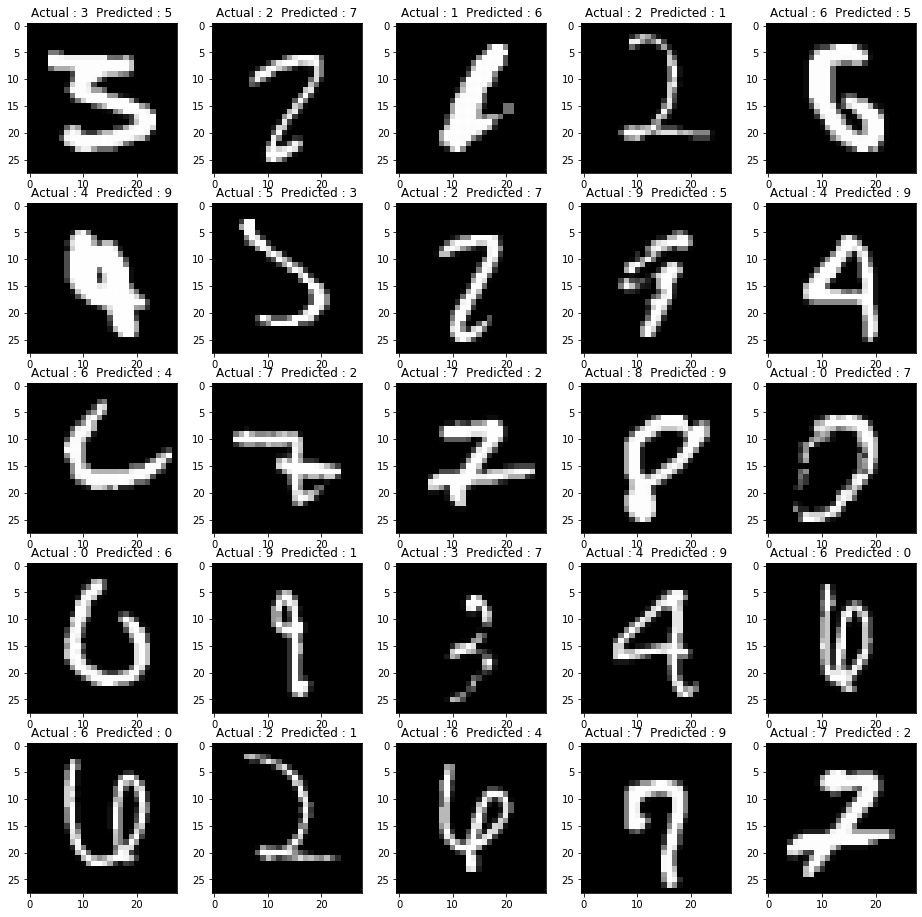

In [0]:
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
evalloader_args = dict(shuffle=True, batch_size=10000, num_workers=4, pin_memory=True)
eval_loader = torch.utils.data.DataLoader(test, **evalloader_args)
for eval_data, eval_target in eval_loader:
  eval_data, eval_target = eval_data.to(device), eval_target.to(device)
  eval_out = model2(eval_data)
  target_lbl=eval_target.cpu().numpy()
  pred_lbl=eval_out.argmax(1).cpu().numpy()
  fail=[]
  for i in range(10000):
    if target_lbl[i] != pred_lbl[i]:fail.append(i)
  fig = plt.figure(figsize=(16,16))
  cnt=0
  for i in fail[:25]:
    ax=fig.add_subplot(5, 5, cnt+1)
    img=np.squeeze(eval_data[i].cpu().numpy()[0])
    ax.imshow(img, cmap='gray')
    cnt+=1
    ax.set_title("Actual : "+str(target_lbl[i])+"  Predicted : "+str(pred_lbl[i]))
  plt.savefig('L1_Misclassified.png')
  plt.show()

## With L2 Regularisation

In [0]:
model3=None

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model3 = Net2().to(device)
summary(model3, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]             576
       BatchNorm2d-9            [-1, 8, 10, 10]              16
             ReLU-10            [-1, 8, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           1,152
      BatchNorm2d-12             [-1, 16, 8, 8]              32
             ReLU-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses_l2 = []
train_acc = []
test_acc_l2= []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2.append(100. * correct / len(test_loader.dataset))

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model3 = Net2().to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.1,weight_decay=0.001)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model3, device, train_loader, optimizer, epoch)
    test(model3, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.054759591817855835 Batch_id=937 Accuracy=91.35: 100%|██████████| 938/938 [00:17<00:00, 54.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0717, Accuracy: 9791/10000 (97.91%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.24435079097747803 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [00:16<00:00, 66.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9845/10000 (98.45%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.21283447742462158 Batch_id=937 Accuracy=97.01: 100%|██████████| 938/938 [00:17<00:00, 55.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1008, Accuracy: 9708/10000 (97.08%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.07523329555988312 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:17<00:00, 52.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9796/10000 (97.96%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.03359885513782501 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:17<00:00, 53.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1125, Accuracy: 9717/10000 (97.17%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.017827630043029785 Batch_id=937 Accuracy=96.36: 100%|██████████| 938/938 [00:17<00:00, 53.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0798, Accuracy: 9776/10000 (97.76%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.17388027906417847 Batch_id=937 Accuracy=96.35: 100%|██████████| 938/938 [00:16<00:00, 55.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2861, Accuracy: 9017/10000 (90.17%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.5646895170211792 Batch_id=937 Accuracy=96.19: 100%|██████████| 938/938 [00:17<00:00, 53.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1893, Accuracy: 9409/10000 (94.09%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.20159120857715607 Batch_id=937 Accuracy=96.09: 100%|██████████| 938/938 [00:17<00:00, 67.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1676, Accuracy: 9518/10000 (95.18%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.09340173006057739 Batch_id=937 Accuracy=96.14: 100%|██████████| 938/938 [00:16<00:00, 55.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5891, Accuracy: 8255/10000 (82.55%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.20524010062217712 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:17<00:00, 53.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1571, Accuracy: 9531/10000 (95.31%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.07659897953271866 Batch_id=937 Accuracy=96.19: 100%|██████████| 938/938 [00:17<00:00, 55.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1591, Accuracy: 9491/10000 (94.91%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.17626185715198517 Batch_id=937 Accuracy=96.26: 100%|██████████| 938/938 [00:16<00:00, 55.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1177, Accuracy: 9609/10000 (96.09%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.19639304280281067 Batch_id=937 Accuracy=96.16: 100%|██████████| 938/938 [00:17<00:00, 53.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1267, Accuracy: 9586/10000 (95.86%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.12166688591241837 Batch_id=937 Accuracy=96.21: 100%|██████████| 938/938 [00:17<00:00, 54.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3901, Accuracy: 8703/10000 (87.03%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.24277618527412415 Batch_id=937 Accuracy=96.17: 100%|██████████| 938/938 [00:17<00:00, 54.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2730, Accuracy: 9131/10000 (91.31%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.039840251207351685 Batch_id=937 Accuracy=96.23: 100%|██████████| 938/938 [00:17<00:00, 53.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1561, Accuracy: 9471/10000 (94.71%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.16405105590820312 Batch_id=937 Accuracy=96.21: 100%|██████████| 938/938 [00:17<00:00, 54.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1366, Accuracy: 9588/10000 (95.88%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.18801775574684143 Batch_id=937 Accuracy=96.38: 100%|██████████| 938/938 [00:17<00:00, 54.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1031, Accuracy: 9701/10000 (97.01%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.09461323916912079 Batch_id=937 Accuracy=96.25: 100%|██████████| 938/938 [00:18<00:00, 52.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1386, Accuracy: 9538/10000 (95.38%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.17364749312400818 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:17<00:00, 54.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2849, Accuracy: 9081/10000 (90.81%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.09698574990034103 Batch_id=937 Accuracy=96.51: 100%|██████████| 938/938 [00:17<00:00, 54.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2180, Accuracy: 9348/10000 (93.48%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.06926761567592621 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:17<00:00, 53.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0975, Accuracy: 9713/10000 (97.13%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.10261605679988861 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [00:16<00:00, 55.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 8975/10000 (89.75%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.11158154904842377 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:17<00:00, 54.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3638, Accuracy: 8825/10000 (88.25%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.3452761769294739 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:17<00:00, 53.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2092, Accuracy: 9362/10000 (93.62%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.1264527291059494 Batch_id=937 Accuracy=96.75: 100%|██████████| 938/938 [00:17<00:00, 54.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0906, Accuracy: 9725/10000 (97.25%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.10912995040416718 Batch_id=937 Accuracy=96.88: 100%|██████████| 938/938 [00:17<00:00, 54.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2257, Accuracy: 9260/10000 (92.60%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.10451624542474747 Batch_id=937 Accuracy=96.94: 100%|██████████| 938/938 [00:17<00:00, 54.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1106, Accuracy: 9658/10000 (96.58%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.12381109595298767 Batch_id=937 Accuracy=97.01: 100%|██████████| 938/938 [00:17<00:00, 54.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1070, Accuracy: 9670/10000 (96.70%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.08213656395673752 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:17<00:00, 53.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9796/10000 (97.96%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.15568484365940094 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:16<00:00, 55.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 9809/10000 (98.09%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.04427006095647812 Batch_id=937 Accuracy=97.52: 100%|██████████| 938/938 [00:17<00:00, 54.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0838, Accuracy: 9753/10000 (97.53%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.0228927880525589 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:17<00:00, 53.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9835/10000 (98.35%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.1362859159708023 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:16<00:00, 55.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9831/10000 (98.31%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.024860918521881104 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:17<00:00, 53.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9812/10000 (98.12%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.041941769421100616 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:17<00:00, 54.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9914/10000 (99.14%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.07485662400722504 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:16<00:00, 55.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9927/10000 (99.27%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.01978076994419098 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:17<00:00, 53.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9925/10000 (99.25%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.04413093626499176 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 54.93it/s]



Test set: Average loss: 0.0252, Accuracy: 9933/10000 (99.33%)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


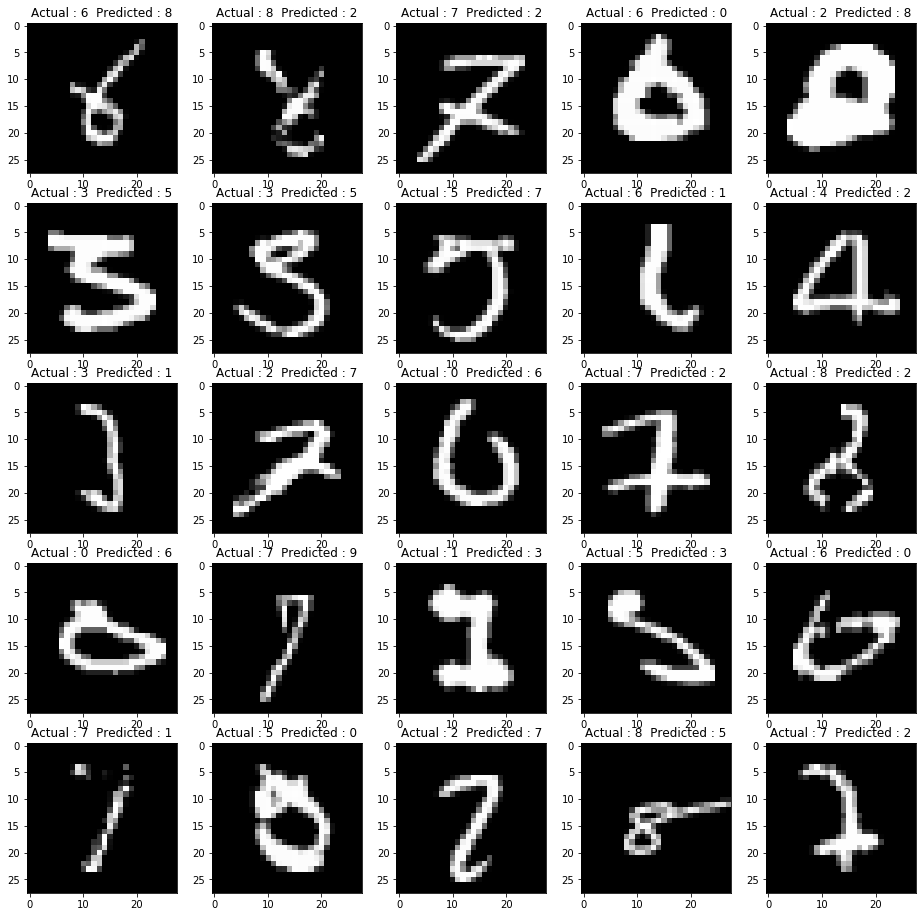

In [0]:
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
evalloader_args = dict(shuffle=True, batch_size=10000, num_workers=4, pin_memory=True)
eval_loader = torch.utils.data.DataLoader(test, **evalloader_args)
for eval_data, eval_target in eval_loader:
  eval_data, eval_target = eval_data.to(device), eval_target.to(device)
  eval_out = model3(eval_data)
  target_lbl=eval_target.cpu().numpy()
  pred_lbl=eval_out.argmax(1).cpu().numpy()
  fail=[]
  for i in range(10000):
    if target_lbl[i] != pred_lbl[i]:fail.append(i)
  fig = plt.figure(figsize=(16,16))
  cnt=0
  for i in fail[:25]:
    ax=fig.add_subplot(5, 5, cnt+1)
    img=np.squeeze(eval_data[i].cpu().numpy()[0])
    ax.imshow(img, cmap='gray')
    cnt+=1
    ax.set_title("Actual : "+str(target_lbl[i])+"  Predicted : "+str(pred_lbl[i]))
  plt.savefig('L2_Misclassified.png')
  plt.show()

## With L1 and L2 Regularisation

In [0]:
model=None

In [0]:
from tqdm import tqdm

train_losses = []
test_losses_l1l2 = []
train_acc = []
test_acc_l1l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))

    classify_loss  = criterion(y_pred, target)
    factor = 0.0005
    loss = classify_loss + factor * reg_loss

    train_losses.append(loss)

   

     #Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1l2.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1l2.append(100. * correct / len(test_loader.dataset))

In [0]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1,weight_decay=0.001)
scheduler = OneCycleLR(optimizer,max_lr=0.4,total_steps=40)

for epoch in range(1, 41):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.016000000000000014]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.3168473541736603 Batch_id=937 Accuracy=91.30: 100%|██████████| 938/938 [00:18<00:00, 50.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9727/10000 (97.27%)

Epoch: 2 Learning_Rate [0.023777349066016473]


Loss=0.3014565110206604 Batch_id=937 Accuracy=96.09: 100%|██████████| 938/938 [00:18<00:00, 49.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1426, Accuracy: 9600/10000 (96.00%)

Epoch: 3 Learning_Rate [0.04647932169641322]


Loss=0.40013623237609863 Batch_id=937 Accuracy=95.67: 100%|██████████| 938/938 [00:18<00:00, 50.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.6647, Accuracy: 8163/10000 (81.63%)

Epoch: 4 Learning_Rate [0.08226673908250526]


Loss=0.380147784948349 Batch_id=937 Accuracy=95.21: 100%|██████████| 938/938 [00:18<00:00, 49.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2615, Accuracy: 9174/10000 (91.74%)

Epoch: 5 Learning_Rate [0.1282403175036378]


Loss=0.4809449017047882 Batch_id=937 Accuracy=94.70: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3113, Accuracy: 8997/10000 (89.97%)

Epoch: 6 Learning_Rate [0.18067555105152924]


Loss=0.33352354168891907 Batch_id=937 Accuracy=94.39: 100%|██████████| 938/938 [00:18<00:00, 50.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5206, Accuracy: 8316/10000 (83.16%)

Epoch: 7 Learning_Rate [0.23532444894847074]


Loss=0.35849517583847046 Batch_id=937 Accuracy=94.31: 100%|██████████| 938/938 [00:18<00:00, 49.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2168, Accuracy: 9372/10000 (93.72%)

Epoch: 8 Learning_Rate [0.2877596824963622]


Loss=0.4039957523345947 Batch_id=937 Accuracy=94.23: 100%|██████████| 938/938 [00:19<00:00, 48.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4972, Accuracy: 8404/10000 (84.04%)

Epoch: 9 Learning_Rate [0.3337332609174947]


Loss=0.36627233028411865 Batch_id=937 Accuracy=93.84: 100%|██████████| 938/938 [00:19<00:00, 48.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.7135, Accuracy: 7817/10000 (78.17%)

Epoch: 10 Learning_Rate [0.3695206783035868]


Loss=0.44496145844459534 Batch_id=937 Accuracy=93.79: 100%|██████████| 938/938 [00:18<00:00, 49.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4331, Accuracy: 8659/10000 (86.59%)

Epoch: 11 Learning_Rate [0.3922226509339835]


Loss=0.44357842206954956 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:20<00:00, 46.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4161, Accuracy: 8531/10000 (85.31%)

Epoch: 12 Learning_Rate [0.4]


Loss=0.4252234697341919 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [00:19<00:00, 48.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.0967, Accuracy: 6622/10000 (66.22%)

Epoch: 13 Learning_Rate [0.3987424470088807]


Loss=0.8404560089111328 Batch_id=937 Accuracy=93.57: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4919, Accuracy: 8226/10000 (82.26%)

Epoch: 14 Learning_Rate [0.39498560249403497]


Loss=0.3805871605873108 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [00:18<00:00, 49.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.6650, Accuracy: 7986/10000 (79.86%)

Epoch: 15 Learning_Rate [0.38877671095500926]


Loss=0.36726802587509155 Batch_id=937 Accuracy=93.85: 100%|██████████| 938/938 [00:18<00:00, 49.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.7324, Accuracy: 7592/10000 (75.92%)

Epoch: 16 Learning_Rate [0.38019385280538953]


Loss=0.4214209318161011 Batch_id=937 Accuracy=94.02: 100%|██████████| 938/938 [00:18<00:00, 50.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5842, Accuracy: 7960/10000 (79.60%)

Epoch: 17 Learning_Rate [0.36934496246629744]


Loss=0.437469482421875 Batch_id=937 Accuracy=93.82: 100%|██████████| 938/938 [00:18<00:00, 49.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.8507, Accuracy: 7585/10000 (75.85%)

Epoch: 18 Learning_Rate [0.35636647102842]


Loss=0.3615880012512207 Batch_id=937 Accuracy=94.18: 100%|██████████| 938/938 [00:18<00:00, 50.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.1419, Accuracy: 6888/10000 (68.88%)

Epoch: 19 Learning_Rate [0.34142159055188454]


Loss=0.33593258261680603 Batch_id=937 Accuracy=93.90: 100%|██████████| 938/938 [00:19<00:00, 49.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2311, Accuracy: 9370/10000 (93.70%)

Epoch: 20 Learning_Rate [0.3246982615799052]


Loss=0.5671499967575073 Batch_id=937 Accuracy=94.06: 100%|██████████| 938/938 [00:18<00:00, 49.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.8773, Accuracy: 7422/10000 (74.22%)

Epoch: 21 Learning_Rate [0.30640678967740614]


Loss=0.6946465373039246 Batch_id=937 Accuracy=93.97: 100%|██████████| 938/938 [00:18<00:00, 50.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 1.2778, Accuracy: 6927/10000 (69.27%)

Epoch: 22 Learning_Rate [0.28677720071652035]


Loss=0.37430867552757263 Batch_id=937 Accuracy=94.18: 100%|██████████| 938/938 [00:19<00:00, 48.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.9466, Accuracy: 7168/10000 (71.68%)

Epoch: 23 Learning_Rate [0.2660563481677839]


Loss=0.48370954394340515 Batch_id=937 Accuracy=94.04: 100%|██████████| 938/938 [00:18<00:00, 49.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.6475, Accuracy: 7863/10000 (78.63%)

Epoch: 24 Learning_Rate [0.24450480877451572]


Loss=0.5031561851501465 Batch_id=937 Accuracy=93.98: 100%|██████████| 938/938 [00:18<00:00, 50.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5547, Accuracy: 8031/10000 (80.31%)

Epoch: 25 Learning_Rate [0.2223936056490807]


Loss=0.32622888684272766 Batch_id=937 Accuracy=94.58: 100%|██████████| 938/938 [00:19<00:00, 48.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1849, Accuracy: 9451/10000 (94.51%)

Epoch: 26 Learning_Rate [0.2000008]


Loss=0.3009112775325775 Batch_id=937 Accuracy=94.58: 100%|██████████| 938/938 [00:19<00:00, 49.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4350, Accuracy: 8391/10000 (83.91%)

Epoch: 27 Learning_Rate [0.1776079943509193]


Loss=0.37224411964416504 Batch_id=937 Accuracy=94.71: 100%|██████████| 938/938 [00:18<00:00, 49.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3399, Accuracy: 8839/10000 (88.39%)

Epoch: 28 Learning_Rate [0.1554967912254843]


Loss=0.320620596408844 Batch_id=937 Accuracy=94.81: 100%|██████████| 938/938 [00:19<00:00, 48.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4609, Accuracy: 8284/10000 (82.84%)

Epoch: 29 Learning_Rate [0.1339452518322162]


Loss=0.5967706441879272 Batch_id=937 Accuracy=94.97: 100%|██████████| 938/938 [00:18<00:00, 51.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.7456, Accuracy: 7542/10000 (75.42%)

Epoch: 30 Learning_Rate [0.11322439928347969]


Loss=0.3750509023666382 Batch_id=937 Accuracy=95.20: 100%|██████████| 938/938 [00:18<00:00, 50.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.4351, Accuracy: 8549/10000 (85.49%)

Epoch: 31 Learning_Rate [0.09359481032259394]


Loss=0.3150288760662079 Batch_id=937 Accuracy=95.41: 100%|██████████| 938/938 [00:19<00:00, 48.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1762, Accuracy: 9496/10000 (94.96%)

Epoch: 32 Learning_Rate [0.0753033384200948]


Loss=0.4159129858016968 Batch_id=937 Accuracy=95.73: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.3178, Accuracy: 8882/10000 (88.82%)

Epoch: 33 Learning_Rate [0.05858000944811546]


Loss=0.3198196291923523 Batch_id=937 Accuracy=95.76: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1874, Accuracy: 9449/10000 (94.49%)

Epoch: 34 Learning_Rate [0.04363512897158001]


Loss=0.2830275595188141 Batch_id=937 Accuracy=96.27: 100%|██████████| 938/938 [00:19<00:00, 48.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.5689, Accuracy: 8053/10000 (80.53%)

Epoch: 35 Learning_Rate [0.030656637533702562]


Loss=0.31652945280075073 Batch_id=937 Accuracy=96.53: 100%|██████████| 938/938 [00:18<00:00, 50.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1825, Accuracy: 9453/10000 (94.53%)

Epoch: 36 Learning_Rate [0.019807747194610516]


Loss=0.23643915355205536 Batch_id=937 Accuracy=96.95: 100%|██████████| 938/938 [00:18<00:00, 51.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1064, Accuracy: 9687/10000 (96.87%)

Epoch: 37 Learning_Rate [0.011224889044990732]


Loss=0.26644283533096313 Batch_id=937 Accuracy=97.16: 100%|██████████| 938/938 [00:19<00:00, 48.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0791, Accuracy: 9788/10000 (97.88%)

Epoch: 38 Learning_Rate [0.005015997505965022]


Loss=0.22992976009845734 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:18<00:00, 50.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9832/10000 (98.32%)

Epoch: 39 Learning_Rate [0.001259152991119394]


Loss=0.18641051650047302 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:18<00:00, 51.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9895/10000 (98.95%)

Epoch: 40 Learning_Rate [1.6e-06]


Loss=0.11875095963478088 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]



Test set: Average loss: 0.0376, Accuracy: 9906/10000 (99.06%)



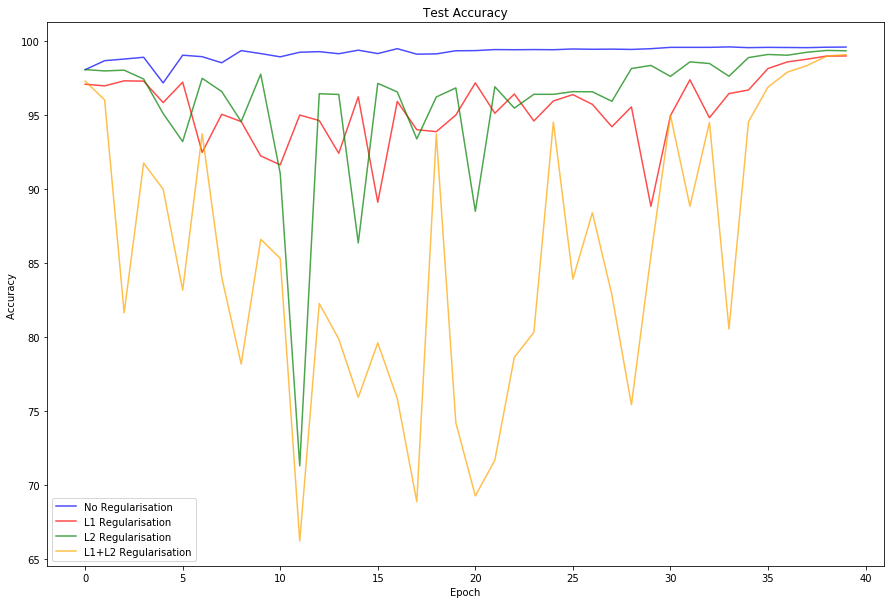

In [0]:
fig= plt.figure(figsize=(15,10))
ax= fig.add_subplot(1,1,1)
ax.plot(test_acc_1, color='blue',label='No Regularisation', alpha=0.7)
ax.plot(test_acc_l1, color='red',label='L1 Regularisation', alpha=0.7)
ax.plot(test_acc_l2, color='green',label='L2 Regularisation', alpha=0.7)
ax.plot(test_acc_l1l2, color='orange',label='L1+L2 Regularisation', alpha=0.7)
#ax.plot( train_acc, color='red',label='Train')
ax.legend()
#ax.set_ylim(96,100)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy ')
ax.set_title('Test Accuracy')
plt.savefig('Accuracy.png')

plt.show()

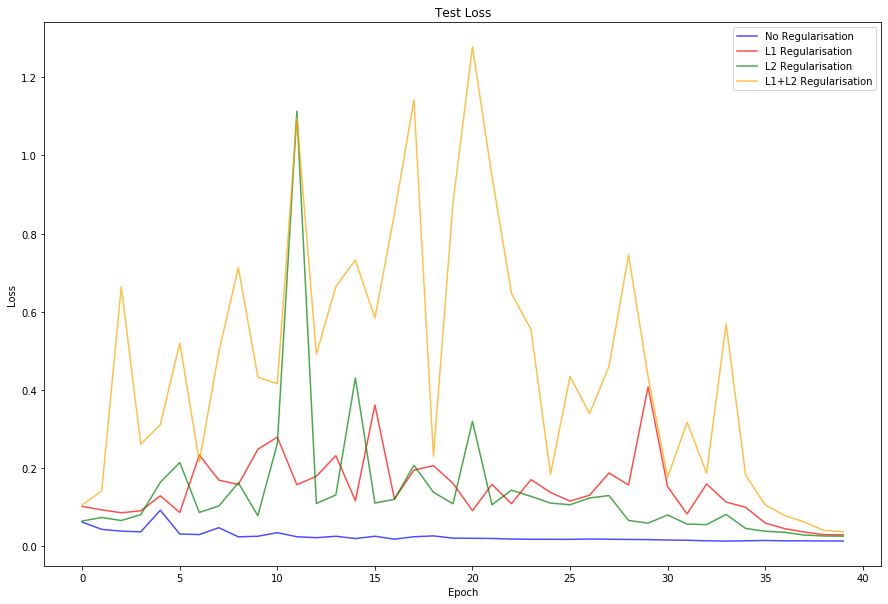

In [0]:
fig= plt.figure(figsize=(15,10))
ax2= fig.add_subplot(1,1,1)
ax2.plot(test_losses_1, color='blue', label='No Regularisation', alpha=0.7)
ax2.plot(test_losses_l1, color='red', label='L1 Regularisation', alpha=0.7)
ax2.plot(test_losses_l2, color='green', label='L2 Regularisation', alpha=0.7)
ax2.plot(test_losses_l1l2, color='orange', label='L1+L2 Regularisation', alpha=0.7)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')
plt.savefig('Loss.png')
plt.show()


In [0]:
model=None

In [0]:
use_cuda = torch.cuda.is_available()

cuda = torch.cuda.is_available()
correct = 0
total = 0
incorrect_examples=[]
incorrect_labels=[]
incorrect_preds=[]
for (i, [images, labels]) in enumerate(test_loader):
    images = (images.view(-1,1, 28,28)).to(device)
    outputs = model(images)
    _, predicted = torch.min(outputs.data, 1)
    total += labels.size(0)                    
    correct += (predicted == labels.to(device)).sum() 
    print('Accuracy: %d %%' % (100 * correct / total))

    # if (predicted==labels).item()==0:
    #     incorrect_examples.append(images.numpy())

    idxs_mask = (predicted == labels).view(-1)
    incorrect_examples.append(images[idxs_mask].numpy()) 
    incorrect_labels.append(labels[idxs_mask])
    incorrect_preds.append(predicted[idxs_mask])

Accuracy: 0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


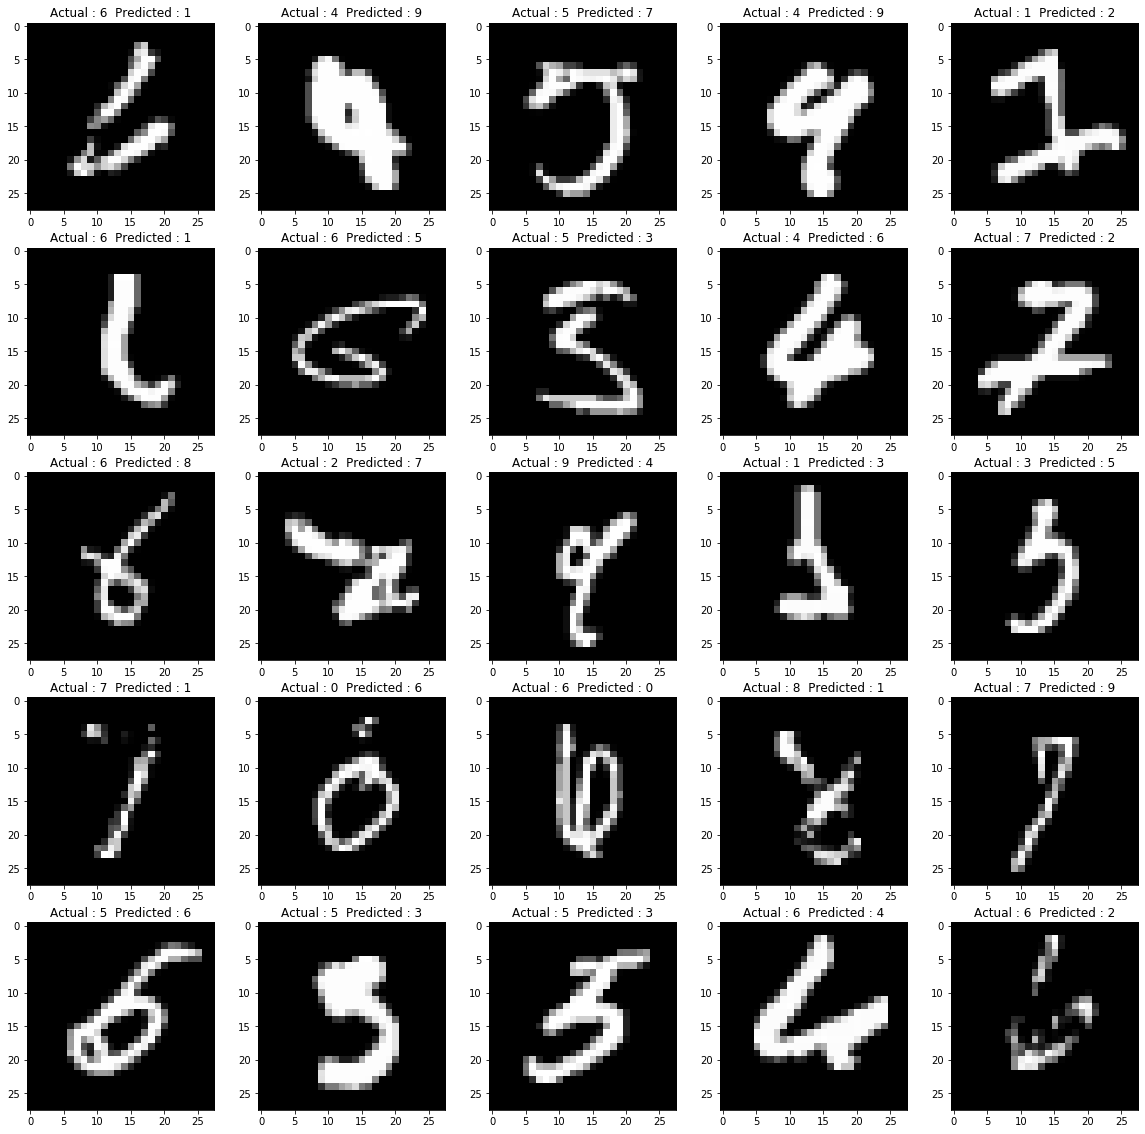

In [0]:
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
evalloader_args = dict(shuffle=True, batch_size=10000, num_workers=4, pin_memory=True)
eval_loader = torch.utils.data.DataLoader(test, **evalloader_args)
for eval_data, eval_target in eval_loader:
  eval_data, eval_target = eval_data.to(device), eval_target.to(device)
  eval_out = model(eval_data)
  target_lbl=eval_target.cpu().numpy()
  pred_lbl=eval_out.argmax(1).cpu().numpy()
  fail=[]
  for i in range(10000):
    if target_lbl[i] != pred_lbl[i]:fail.append(i)
  fig = plt.figure(figsize=(20,20))
  cnt=0
  for i in fail[:25]:
    ax=fig.add_subplot(5, 5, cnt+1)
    img=np.squeeze(eval_data[i].cpu().numpy()[0])
    ax.imshow(img, cmap='gray')
    cnt+=1
    ax.set_title("Actual : "+str(target_lbl[i])+"  Predicted : "+str(pred_lbl[i]))
